# <span style="color:royalblue"> Rover Project Test Notebook </span><a id='0'></a>

## Brief Information

This mini project represents a rover project of sample searching and returning of NASA. The passing requirement of this project is to map at least ***40%*** of the environment at ***60%*** of fidelity and locate at least ***one*** rock sample in the map.

Belows are python code that tell the robot how to navigate around the environment and search for rock samples but not picking them up. This notebook will only concentrate on how the perception of the robot will implemented in **perception.py** file. **perception.py** will be used in the project to help the robot achieve the passing requirement above. The perception pipeline has following order: 

***Perspective Transfrom*** --> ***Apply Color Thresholding*** --> ***Rover Coordinates Transfrom*** --> ***Apply Image Processing Function***

## <span style="color:black"> Notebook Contents </span>

#### <a href='#1'> 1/ Packages Importation </a>

#### <a href='#2'> 2/ Data Calibration </a>

#### <a href='#3'> 3/ Perspective Transform Function </a>

#### <a href='#4'> 4/ Color Thresholding </a>

#### <a href='#5'> 5/ Coordinate Transformations </a>




In [1]:
%%HTML
<style> code {background-color : tan !important;} </style>

## <span style="color:black"> 1/ Packages Importation </span><a id='1'></a>

### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio


## <span style="color:black"> 2/ Data Calibration</span><a id='2'></a>
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

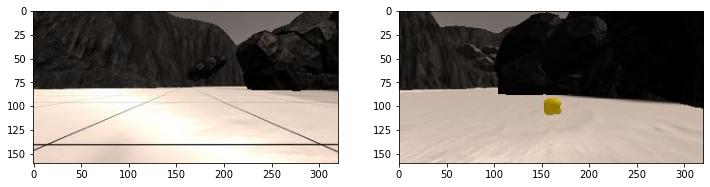

In [3]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/grid_image.jpg'
example_rock = '../calibration_images/rock_image.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## <span style="color:black"> 3/ Perspective Transform </span><a id='3'></a>

Define the perspective transform function from the lesson and test it on an image.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

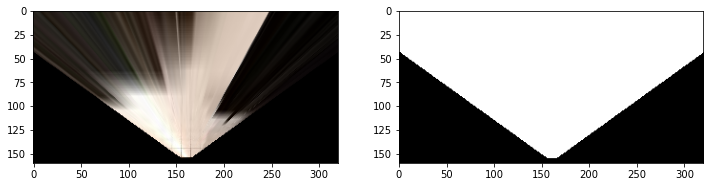

In [4]:
# Randomly select a record image in test_dataset folder
#path = '../test_dataset/IMG/*' # Data folder from Udacity
path = '../record_data/IMG/*'   # Data folder I recorded myself
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    # Keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Create a mask of a field of view of the robot
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    return warped, mask

# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 

# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6

# Set a list of coordinate of the square in the source image.
source = np.float32([[14,  140], 
                     [301, 140],
                     [200,  96], 
                     [118,  96]])

# Calculate coordinates of the destination pixel.
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] -              bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] -              bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                          [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                          ])

warped, mask = perspect_transform(grid_img, source, destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)
#imageio.imwrite('../output/warped_example.jpg', warped)
#scipy.misc.imsave('../output/mask_example.jpg', mask)

## <span style="color:black"> 4/ Color Thresholding </span><a id='4'></a>
Define the color thresholding function from the lesson and apply it to the warped image.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

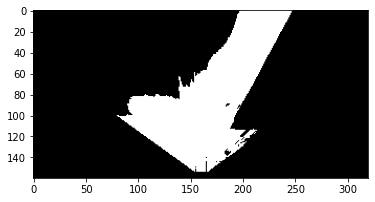

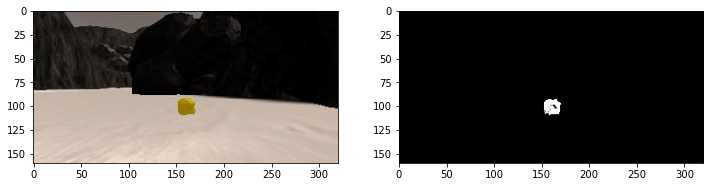

In [5]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    above_thresh =   ((img[:,:,0] > rgb_thresh[0]) \
                    & (img[:,:,1] > rgb_thresh[1]) \
                    & (img[:,:,2] > rgb_thresh[2]))
    
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def find_rock(img, levels=(110, 110, 50)):
    rock_pix =  ((img[:,:,0] > levels[0]) \
               & (img[:,:,1] > levels[1]) \
               & (img[:,:,2] < levels[2]))
    
    
    color_select = np.zeros_like(img[:,:,0])
    # Index the array of zeros with the boolean array and set to 1
    color_select[rock_pix] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
rock_map = find_rock(rock_img)

plt.imshow(threshed, cmap='gray')
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## <span style="color:black"> 5/ Coordinate Transformations </span><a id='5'></a>
Define the functions used to do coordinate transforms and apply them to an image.
### <a href='#0'><span style="color:royalblue"> Back to content </span></a>

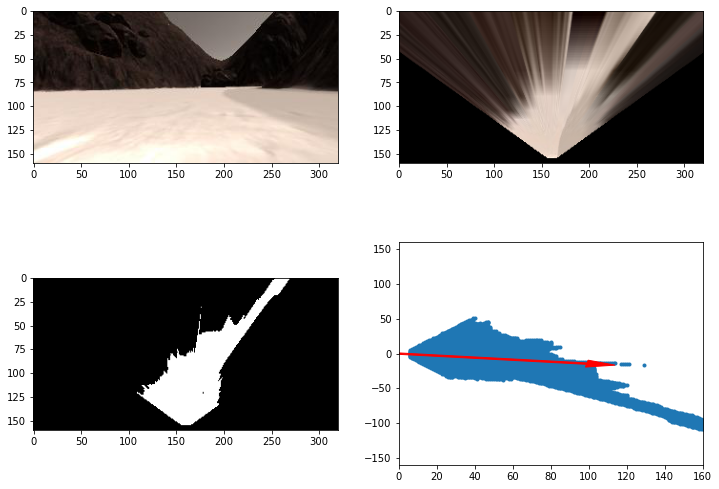

In [9]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)
#threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

